In [62]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
from calculations import *
from plot_helper import *
import matplotlib.patches as patches
import PIL

import cv2 as cv
from pytesseract import pytesseract 
import re

from ColorSegment import *
from rePatterns import *

model = YOLO("models/WhatsappWindow_Models/v4.pt")

In [63]:
monitor_resoution = (2880, 1864)
current_shape = (1920,1080)
image_path = "testing_image/ss7.png"
original_size = 896
resized_size = closestNumber(min(monitor_resoution), 32)

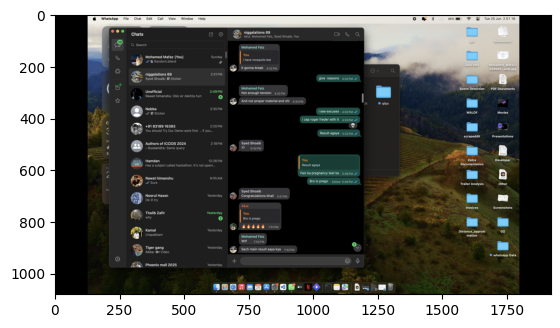

In [64]:
plt.imshow(resize_and_center_image(image_path=image_path, target_shape=current_shape))


0: 576x1024 2 windows, 1578.1ms
Speed: 12.7ms preprocess, 1578.1ms inference, 11.2ms postprocess per image at shape (1, 3, 576, 1024)


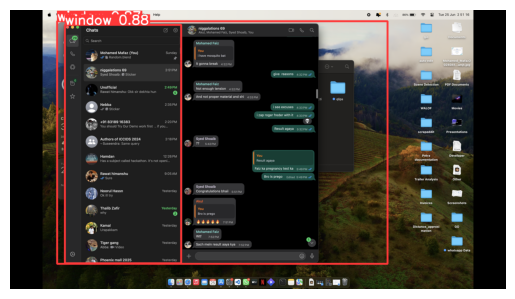

In [65]:
plot, boxes = predict_and_show(model = model, image_path=image_path, target_shape=current_shape)

Shape: (1641, 2217, 3)


(-0.5, 2216.5, 1640.5, -0.5)

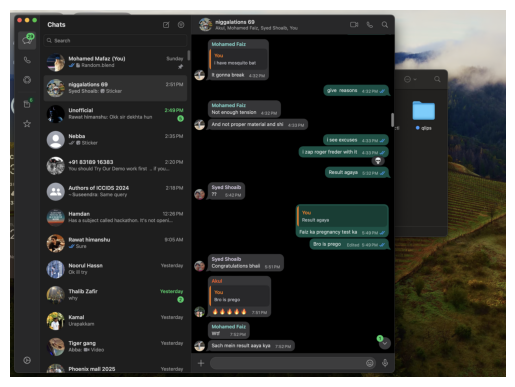

In [66]:
image_cropped = crop_resizebbox(image_path=image_path, current_shape=current_shape
                 ,target_shape=monitor_resoution, boxes_xyxy=boxes.xyxy[-1], margin_shape = (150,10))

plt.imshow(image_cropped)
plt.axis("off")

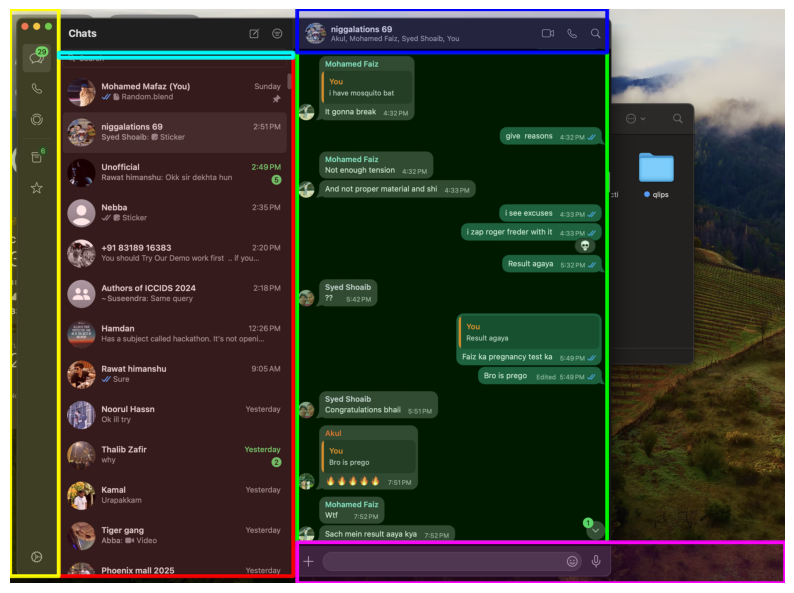

In [67]:
bboxes = WhatsappSegment(cv.cvtColor(image_cropped, cv.COLOR_RGB2BGR), alpha=0.1, show=True)

No circles were found


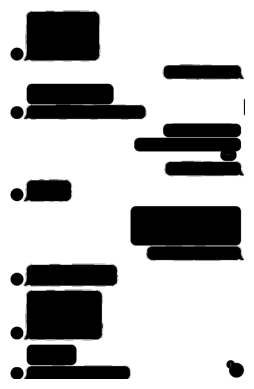

In [68]:
chat_mask_circle_removed,_ = remove_circle(image_cropped, ismask=False, bbox=bboxes['chat_bbox'], show=True, maxRadius=300)

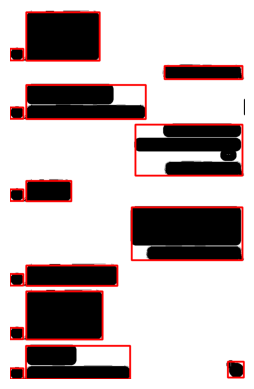

[(61, 12, 338, 195),
 (0, 150, 50, 194),
 (583, 215, 877, 265),
 (61, 287, 512, 416),
 (0, 372, 50, 415),
 (473, 437, 877, 630),
 (61, 650, 231, 727),
 (0, 682, 50, 726),
 (459, 750, 877, 950),
 (61, 970, 405, 1047),
 (0, 1002, 50, 1046),
 (61, 1068, 349, 1250),
 (0, 1206, 49, 1249),
 (60, 1274, 453, 1400),
 (822, 1334, 882, 1394),
 (0, 1359, 50, 1400)]

In [69]:
message_bbox = chat_message_bbox(chat_mask_circle_removed, show=True, blur=20)
message_bbox = sorted(message_bbox, key=lambda x: x[1])
message_bbox

In [70]:
labels = whosaid(message_bbox=message_bbox)

In [71]:
chats_dict = {}

chat_bbox = bboxes['chat_bbox']
chat_image = image_cropped[chat_bbox[1]:chat_bbox[3], chat_bbox[0]:chat_bbox[2]]
for label, message_box in enumerate(message_bbox):
    message = chat_image[message_box[1]:message_box[3], message_box[0]:message_box[2]]
    message_text = pytesseract.image_to_string(message)
    if message_text != '':
        time, text_without_time = extract_time_and_remove(message_text)
        if labels[label] == 0 : chats_dict[f"Sender {label}"] = {"message_text": text_without_time, "dateOrTime": time}
        else: chats_dict[f"User {label}"] = {"message_text": message_text, "dateOrTime": time}

chats_dict

{'Sender 0': {'message_text': 'Mohamed Faiz\n\nYou\ni have mosquito bat\n\nIt gonna break',
  'dateOrTime': '4:32pm'},
 'User 2': {'message_text': 'give reasons 4:32PM /\n', 'dateOrTime': '4:32PM'},
 'Sender 3': {'message_text': 'Mohamed Faiz\nNot enough tension \n\nAnd not proper material and shi',
  'dateOrTime': '4:32pm'},
 'User 5': {'message_text': 'isee excuses 4:33PM\n\ni zap roger freder withit 4:33pm\n\nResult agaya 5:32PM\n',
  'dateOrTime': '4:33PM'},
 'Sender 6': {'message_text': 'Syed Shoaib\n22', 'dateOrTime': '5:42PM'},
 'User 8': {'message_text': 'You\nResult agaya\n\nFaiz ka pregnancy test ka 5:49PM /\n\nBrois prego Edited 5:49PM\n',
  'dateOrTime': '5:49PM'},
 'Sender 9': {'message_text': 'Syed Shoaib\nCongratulations bhaii',
  'dateOrTime': '5:51pm'},
 'Sender 11': {'message_text': 'Akul\n\nYou\nBro is prego\n\n66S SS z51—M\n',
  'dateOrTime': None},
 'Sender 13': {'message_text': 'Mohamed Faiz\nWtf \n\nSach mein result aaya kya',
  'dateOrTime': '7:52PM'}}

In [72]:
history_bbox = bboxes['history_bbox']
history_image = image_cropped[history_bbox[1]:history_bbox[3],history_bbox[0]:history_bbox[2]]
history_mask = extract_color(history_image, (0,0,30), (0,0,50), blur=(0,0), show=False)
history_mask

array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

1 found!!


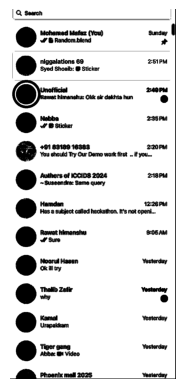

1 found!!


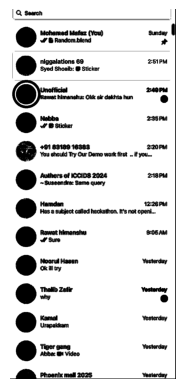

1 found!!


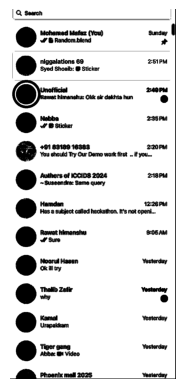

1 found!!


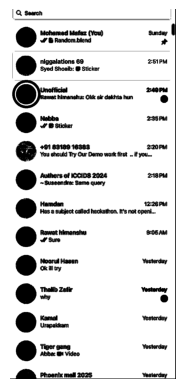

1 found!!


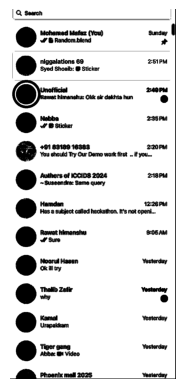

1 found!!


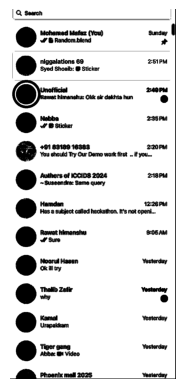

5 found!!


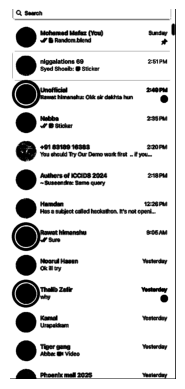

15 found!!


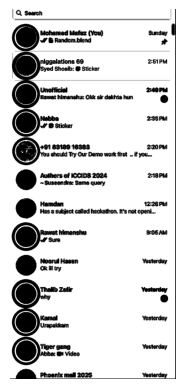

22 found!!


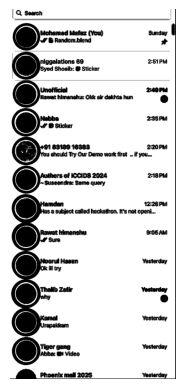

In [73]:
history_bbox = bboxes['history_bbox']
history_image = image_cropped[history_bbox[1]:history_bbox[3],history_bbox[0]:history_bbox[2]]
history_mask = extract_color(history_image, (0,0,30), (0,0,50), blur=(0,0), show=False)

count = 0
dp = 0.5
circles = [0]
while len(circles) <= 5 or len(circles) <= 15:
    _, circles = remove_circle(history_mask.copy(), ismask=True, bbox=bboxes['history_bbox'], show=True, maxRadius=300, minDist=0.01,
                param1=50, param2=90, dp=round(dp,1), circle_color = (0,255,0), thickness=10)
    if circles is None: circles = [0]
    dp += 0.1
    count += 1
    if count == 20: break

In [74]:
circles = sorted(circles, key=lambda x: x[1])
circles

[array([ 66, 112,  40]),
 array([ 63, 229,  40]),
 array([ 66, 229,  41]),
 array([ 66, 343,  40]),
 array([ 64, 458,  42]),
 array([ 66, 574,  42]),
 array([ 64, 575,  41]),
 array([ 66, 690,  41]),
 array([ 63, 805,  41]),
 array([ 64, 807,  41]),
 array([ 66, 808,  43]),
 array([ 64, 920,  42]),
 array([ 66, 922,  41]),
 array([  63, 1035,   41]),
 array([  66, 1037,   42]),
 array([  66, 1151,   42]),
 array([  63, 1152,   43]),
 array([  64, 1266,   42]),
 array([  66, 1267,   42]),
 array([  63, 1267,   40]),
 array([  66, 1383,   41]),
 array([  64, 1384,   41])]

In [75]:
history_dict = {}

for cirlce in circles:
    x1 = cirlce[0]+cirlce[2]
    y1 = cirlce[1]-cirlce[2]
    x2 = history_mask.shape[-1]
    y2 = cirlce[1]+cirlce[2]
    history_text = pytesseract.image_to_string(history_image[y1:y2,x1:x2])
    print(history_text)

    name_and_date = history_text.split('\n')[0]
    if name_and_date != '':
        name, date = ''.join(name_and_date.split()[:-1]), ''.join(name_and_date.split()[-1])

        bottom_text = history_text.split('\n')[1:]
        if len(bottom_text) > 1:
            bottom_text = bottom_text[0]
            num_message, histroy_message = extract_and_remove_number(bottom_text)
            
        history_dict[name] = {'dateOrTime': date, 'histroy_message': histroy_message, 'num_message': num_message}

Mohamed Mafaz (You) Sunday
W & Random.blend *

_ niggalations 69 2:51PM
~ Syed Shoaib: @ Sticker

niggalations 69 2:51PM
Syed Shoaib: @ Sticker

Unofficial 2:49 PM
Rawat himanshu: Okk sir dekhta hun (5)

Nebba 2:35 PM
WY @ Sticker

+91 83189 16383 2:20 PM
You should Try Our Demo work first .. if you...

+91 83189 16383 2:20 PM
You should Try Our Demo work first .. if you...

Authors of ICCIDS 2024 2:18PM
~Suseendra: Same query

Hamdan 12:26 PM

| Has a subject called hackathon. It's not openi...

Hamdan 12:26 PM
Has a subject called hackathon. It's not openi...

Hamdan 12:26 PM
Has a subject called hackathon. It's not openi...

Rawat himanshu 9:05 AM
W Sure

Rawat himanshu 9:05 AM
W Sure

Noorul Hassn Yesterday

Ok ill try

Noorul Hassn Yesterday
Ok ill try

Thalib Zafir Yesterday

why (2)

Thalib Zafir Yesterday

why (2)

Kamal Yesterday
Urapakkam

Kamal Yesterday
Urapakkam

Kamal Yesterday
Urapakkam

Tiger gang Yesterday
Abba: @¢ Video

Tiger gang Yesterday
Abba: @¢ Video

